## Groundwater salinisation - hypothetical case
This notebook is aimed to explore the relation between sea level rise and an inland polder area.

In [50]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 3) # set default figure size
plt.rcParams["contour.negative_linestyle"] = 'solid' # set default line style
plt.rcParams["figure.autolayout"] = True # same as tight_layout after every plot

## Present-day: no sea level rise
We assume an (infinite) polder bordering the coastline. The water level in the polder is already below sea level, causing groundwater to flow upwards and exfiltrate in the polder. Investigate how the groundwater head changes for different hydrogeological parameters .

<img src="figs/fig2.2.png" width=400>

In [134]:
# parameters
h_sea = 0 # sea level, m
h_polder = -1 # head in polder area, m
k = 2 # hydraulic conductivity, m/d
H = 10 # aquifer thickness, m
c0 = 1 # resistance beneath sea, d
c1 = 4000 # resistance beneath polder area, d
sal_sea = 16 # salinity of seawater, g Cl/L
sal_polder = 5 # salinity beneath polder, g Cl/L
T = k * H # transmissivity, m2/d
lab0 = np.sqrt(c0 * T) # leakage factor left side, m
lab1 = np.sqrt(c1 * T) # leakage factor right side, m
gamma = (h_sea - h_polder) / (lab0 + lab1) # dimensionless head difference, -

In [135]:
# solution
x = np.hstack((np.linspace(-500, 0, 51), np.linspace(0, 5*lab1, 201)))
h = np.zeros_like(x)
h[x < 0]  = h_sea - lab0 * gamma * np.exp(x[x < 0] / lab0)
h[x >= 0] = h_polder + lab1 * gamma * np.exp(-x[x >= 0] / lab1)
Qx = np.zeros_like(x)
Qx[x<0] = T * gamma * np.exp(x[x<0] / lab0)
Qx[x>=0] = T * gamma * np.exp(-x[x>=0] / lab1)
Q0 = T * gamma

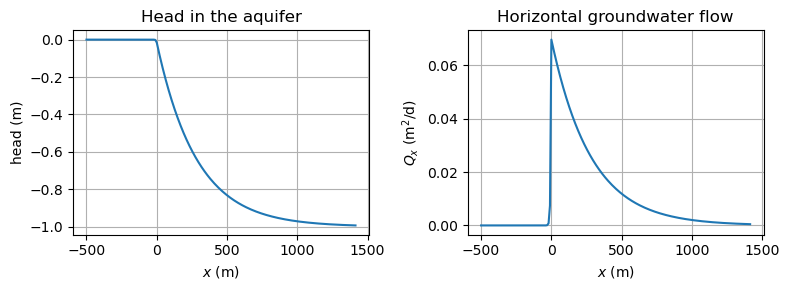

In [136]:
# basic plot
plt.subplot(121)
plt.plot(x, h)
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('head (m)')
plt.title("Head in the aquifer")
plt.subplot(122)
plt.plot(x, Qx)
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('$Q_x$ (m$^2$/d)')
plt.title("Horizontal groundwater flow");

In [137]:
# calculate streamfunction
# solution
psi = np.zeros((2, len(x)))
psi[1] = -Qx
xg = x
zg = [-H, 0]

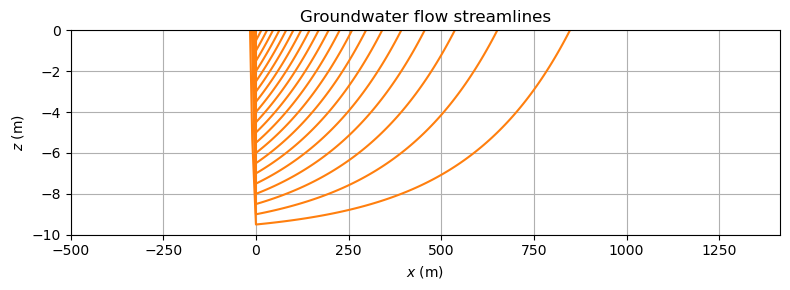

In [138]:
# basic streamline plot
plt.contour(xg, zg, psi, np.linspace(-Q0, 0, 21), colors='C1', linestyles='-')
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('$z$ (m)')
plt.title("Groundwater flow streamlines");

In [139]:
# seepage flux and salt load
# Qz is derivative of Qx, convert to mm
Qz = Qx.copy()
Qz[0] = 0
Qz[1:] = 1_000 * (Qx[:-1] - Qx[1:])
# saltload is just the seepage flux (where positive) times concentration
print(Qz.shape)
SLz = Qz * 0
SLz[Qz>0] = Qz[Qz>0] / 1_000 * sal_polder # m2/d * g/L = kg/d (assume 1m thickness)


(252,)


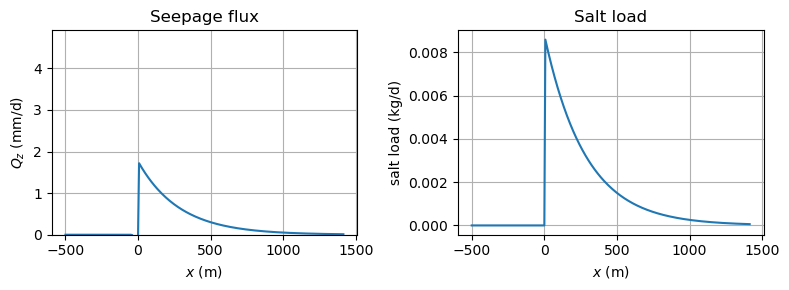

In [140]:
# basic plot
plt.subplot(121)
plt.plot(x, Qz)
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('$Q_z$ (mm/d)')
plt.ylim(bottom=0)
plt.title("Seepage flux")
plt.subplot(122)
plt.plot(x, SLz)
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('salt load (kg/d)')
plt.title("Salt load");

In [141]:
# surface water concentration?
# assume a summer, with say a 0.2 mm/d drainage excess
# assume precipitation salinity of zero
P = .2 # mm/d
sal_average = (SLz[52:] / ((Qz[52:] + P) / 1_000)).mean()
print(f"Averaged concentration: {sal_average:.1f} g/L")
# Flushing water demand
sal_target = np.linspace(0.5,sal_polder,50)
sal_inlet = 0.2
Qown = P + Qz[52:].mean()
Qflush = Qown * (sal_average - sal_target) / (sal_target - sal_inlet)
Qflush = np.fmax(0, Qflush)

Averaged concentration: 2.2 g/L


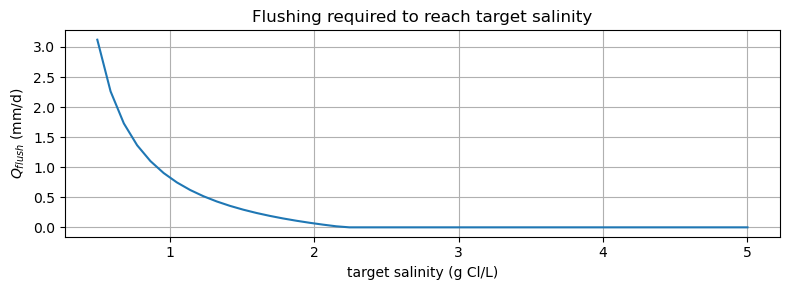

In [142]:
# basic plot: flushing demand vs target concentration
plt.plot(sal_target, Qflush)
plt.grid()
plt.xlabel('target salinity (g Cl/L)')
plt.ylabel('$Q_{flush}$ (mm/d)')
plt.title("Flushing required to reach target salinity");

## Future: sea level rise
Sea level rise changes groundwater flow and salt transport in the system. Investigate how sea level rise affects the head distribution, seepage flux, salt load, and the flushing required to reach a target salinity in the polder water system.

In [143]:
# parameters
h_sea_slr = 5 # sea level after sea level rise, m
gamma_slr = (h_sea_slr - h_polder) / (lab0 + lab1) # dimensionless head difference, -

In [144]:
# solution
h_slr = np.zeros_like(x)
h_slr[x < 0]  = h_sea_slr - lab0 * gamma_slr * np.exp(x[x < 0] / lab0)
h_slr[x >= 0] = h_polder + lab1 * gamma_slr * np.exp(-x[x >= 0] / lab1)
Qx_slr = np.zeros_like(x)
Qx_slr[x<0] = T * gamma_slr * np.exp(x[x<0] / lab0)
Qx_slr[x>=0] = T * gamma_slr * np.exp(-x[x>=0] / lab1)
Q0_slr = T * gamma_slr

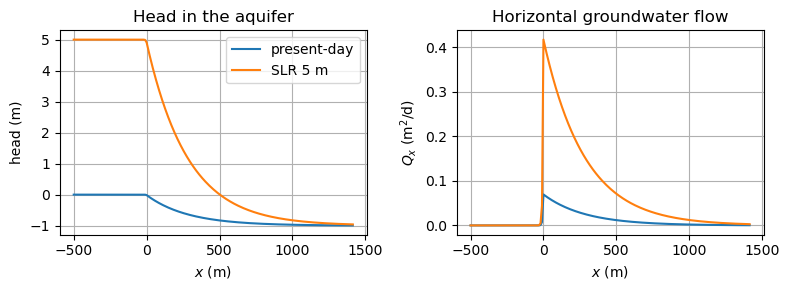

In [145]:
# basic plot
plt.subplot(121)
plt.plot(x, h, label="present-day")
plt.plot(x, h_slr, label=f"SLR {h_sea_slr} m")
plt.grid()
plt.legend()
plt.xlabel('$x$ (m)')
plt.ylabel('head (m)')
plt.title("Head in the aquifer")
plt.subplot(122)
plt.plot(x, Qx)
plt.plot(x, Qx_slr)
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('$Q_x$ (m$^2$/d)')
plt.title("Horizontal groundwater flow");

In [146]:
# seepage flux and salt load
# Qz is derivative of Qx, convert to mm
Qz_slr = Qx.copy()
Qz_slr[0] = 0
Qz_slr[1:] = 1_000 * (Qx_slr[:-1] - Qx_slr[1:])
# saltload is just the seepage flux (where positive) times concentration
SLz_slr = Qz_slr * 0
SLz_slr[Qz_slr>0] = Qz_slr[Qz_slr>0] / 1_000 * sal_polder # m2/d * g/L = kg/d (assume 1m thickness)


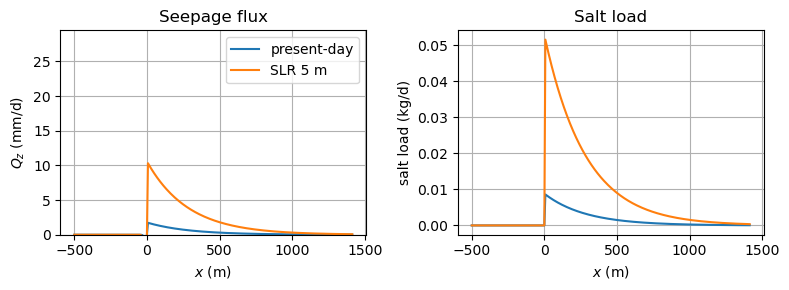

In [147]:
# basic plot
plt.subplot(121)
plt.plot(x, Qz, label="present-day")
plt.plot(x, Qz_slr, label=f"SLR {h_sea_slr} m")
plt.grid()
plt.legend()
plt.xlabel('$x$ (m)')
plt.ylabel('$Q_z$ (mm/d)')
plt.title("Seepage flux")
plt.ylim(bottom=0)
plt.subplot(122)
plt.plot(x, SLz)
plt.plot(x, SLz_slr)
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('salt load (kg/d)')
plt.title("Salt load");

#### Surface water salinity and flushing demand
How much more water is necessary to flush the water system to reach a certain target concentration given sea level rise?

In [148]:
# surface water concentration?
# assume a summer, with say a 0.2 mm/d drainage excess
# assume precipitation salinity of zero
sal_average_slr = (SLz_slr[52:] / ((Qz_slr[52:] + P) / 1_000)).mean()
print(f"Averaged concentration: {sal_average_slr:.1f} g/L")
# Flushing water demand
Qown_slr = P + Qz_slr[52:].mean()
Qflush_slr = Qown_slr * (sal_average_slr - sal_target) / (sal_target - sal_inlet)
Qflush_slr = np.fmax(0, Qflush_slr)

Averaged concentration: 3.7 g/L


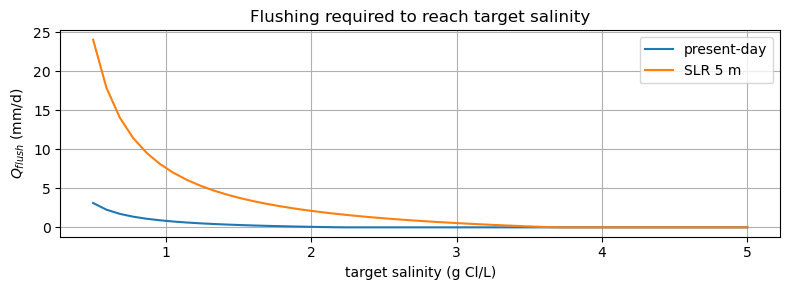

In [149]:
# basic plot: flushing demand vs target concentration
plt.plot(sal_target, Qflush, label="present-day")
plt.plot(sal_target, Qflush_slr, label=f"SLR {h_sea_slr} m")
plt.grid()
plt.legend()
plt.xlabel('target salinity (g Cl/L)')
plt.ylabel('$Q_{flush}$ (mm/d)')
plt.title("Flushing required to reach target salinity");